In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

In [36]:
marketing_campaign = pd.read_csv("marketing_data.csv")

In [37]:
print('\nShape:', marketing_campaign.shape)
print('\nColumns:', marketing_campaign.columns.tolist())

print('\nSample Dt_Customer values:')
print(marketing_campaign['Dt_Customer'].dropna().head())
print('\nIncome dtype and sample:')
print(marketing_campaign[' Income '].dtype)
print(marketing_campaign[' Income '].sample(10))

if 'Dt_Customer' in marketing_campaign.columns:
    try:
        marketing_campaign['Dt_Customer'] = pd.to_datetime(marketing_campaign['Dt_Customer'], dayfirst=True, errors='coerce')
        print('\nDt_Customer parsed. Earliest:', marketing_campaign['Dt_Customer'].min(), 'Latest:', marketing_campaign['Dt_Customer'].max())
    except Exception as e:
        print('Could not parse Dt_Customer:', e)


Shape: (2240, 28)

Columns: ['ID', 'Year_Birth', 'Education', 'Marital_Status', ' Income ', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'Complain', 'Country']

Sample Dt_Customer values:
0    6/16/14
1    6/15/14
2    5/13/14
3    5/11/14
4     4/8/14
Name: Dt_Customer, dtype: object

Income dtype and sample:
object
1075    $42,691.00 
2199    $45,989.00 
1483    $65,316.00 
149     $49,912.00 
1709    $16,626.00 
562      $7,500.00 
2070    $31,632.00 
168     $49,094.00 
985     $13,724.00 
2195    $77,766.00 
Name:  Income , dtype: object

Dt_Customer parsed. Earliest: 2012-01-08 00:00:00 Latest: 2014-12-06 00:00:00


In [38]:
print('\nMissing Income before:', marketing_campaign[' Income '].isna().sum())

if 'Education' in marketing_campaign.columns:
    marketing_campaign['Education'] = marketing_campaign['Education'].astype(str).str.strip().str.title()
    edu_map = {
        'Basic 9y':'Basic', 'Basic 4y':'Basic', 'Basic 6y':'Basic',
        'Graduation':'Graduation', 'Master':'Master', 'Phd':'Phd',
        'Basic':'Basic'
    }
    marketing_campaign['Education'] = marketing_campaign['Education'].replace(edu_map)

if 'Marital_Status' in marketing_campaign.columns:
    marketing_campaign['Marital_Status'] = marketing_campaign['Marital_Status'].astype(str).str.strip().str.title()
    mar_map = {
        'Alone':'Single', 'Absurd':'Other', 'Widow':'Widow', 'Divorced':'Divorced',
        'Separated':'Other', 'Married':'Married', 'Together':'Together', 'Single':'Single',
        'Unknown':'Other', 'YoLo':'Other'
    }
    marketing_campaign['Marital_Status'] = marketing_campaign['Marital_Status'].map(lambda x: mar_map.get(x, x))

if marketing_campaign[' Income '].dtype == object:
    marketing_campaign[' Income '] = marketing_campaign[' Income '].str.replace('[\$,]', '', regex=True)
    marketing_campaign[' Income '] = pd.to_numeric(marketing_campaign[' Income '], errors='coerce')

group_cols = [c for c in ['Education', 'Marital_Status'] if c in marketing_campaign.columns]
if len(group_cols) > 0:
    group_median = marketing_campaign.groupby(group_cols)[' Income '].median().reset_index().rename(columns={' Income ':'median_income'})
    marketing_campaign = marketing_campaign.merge(group_median, on=group_cols, how='left')
    marketing_campaign[' Income '] = marketing_campaign[' Income '].fillna(marketing_campaign['median_income'])
    marketing_campaign.drop(columns=['median_income'], inplace=True)

marketing_campaign[' Income '] = marketing_campaign[' Income '].fillna(marketing_campaign[' Income '].median())
print('Missing Income after:', marketing_campaign[' Income '].isna().sum())


Missing Income before: 24
Missing Income after: 0


In [39]:
if 'Kidhome' in marketing_campaign.columns and 'Teenhome' in marketing_campaign.columns:
    marketing_campaign['Total_Children'] = (
        marketing_campaign['Kidhome'].fillna(0) + marketing_campaign['Teenhome'].fillna(0)
    )
else:
    marketing_campaign['Total_Children'] = marketing_campaign[[c for c in marketing_campaign.columns if 'kid' in c.lower() or 'teen' in c.lower()]].sum(axis=1)
if 'Year_Birth' in marketing_campaign.columns:
    if np.issubdtype(marketing_campaign['Year_Birth'].dtype, np.datetime64):
        marketing_campaign['Year_Birth'] = marketing_campaign['Year_Birth'].dt.year
    marketing_campaign['Year_Birth'] = pd.to_numeric(marketing_campaign['Year_Birth'], errors='coerce')
today = datetime.today()
if 'Year_Birth' in marketing_campaign.columns:
    birth_cols = ['Year_Birth']
    if 'Dt_Customer' in marketing_campaign.columns:
        marketing_campaign['Age'] = marketing_campaign.apply(lambda r: (r['Dt_Customer'].year - int(r['Year_Birth'])) if pd.notnull(r['Dt_Customer']) and pd.notnull(r['Year_Birth']) else (today.year - int(r['Year_Birth']) if pd.notnull(r['Year_Birth']) else np.nan), axis=1)
    else:
        marketing_campaign['Age'] = today.year - marketing_campaign['Year_Birth']
else:
    birth_cols = [c for c in marketing_campaign.columns if 'birth' in c.lower() or 'dob' in c.lower()]
if birth_cols:
    bcol = birth_cols[0]
    marketing_campaign[bcol] = pd.to_datetime(marketing_campaign[bcol], errors='coerce')
    marketing_campaign['Age'] = marketing_campaign.apply(lambda r: (r['Dt_Customer'].year - r[bcol].year) if pd.notnull(r[bcol]) and pd.notnull(r['Dt_Customer']) else (today.year - r[bcol].year if pd.notnull(r[bcol]) else np.nan), axis=1)
else:
    marketing_campaign['Age'] = np.nan

money_cols = [c for c in marketing_campaign.columns if c.lower().startswith('mnt') or 'amount' in c.lower() or c.lower().endswith('spent')]
print('\nDetected monetary columns:', money_cols)
if money_cols:
    marketing_campaign['Total_Spent'] = marketing_campaign[money_cols].sum(axis=1)
else:
    possible = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
    exist = [c for c in possible if c in marketing_campaign.columns]
    if exist:
        marketing_campaign['Total_Spent'] = marketing_campaign[exist].sum(axis=1)
    else:
        marketing_campaign['Total_Spent'] = 0

purchase_cols = [c for c in marketing_campaign.columns if c.lower().startswith('num') and 'purchase' in c.lower()]
if not purchase_cols:
    purchase_cols = [c for c in ['NumWebPurchases','NumCatalogPurchases','NumStorePurchases'] if c in marketing_campaign.columns]
    print('Detected purchase-count columns:', purchase_cols)
if purchase_cols:
    marketing_campaign['Total_Purchases'] = marketing_campaign[purchase_cols].sum(axis=1)
else:
    marketing_campaign['Total_Purchases'] = 0

OUT_DIR = "output"
os.makedirs(OUT_DIR, exist_ok=True)
marketing_campaign.head().to_csv(os.path.join(OUT_DIR, 'processed_head.csv'), index=False)
print('\nSaved processed_head.csv')


Detected monetary columns: ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

Saved processed_head.csv


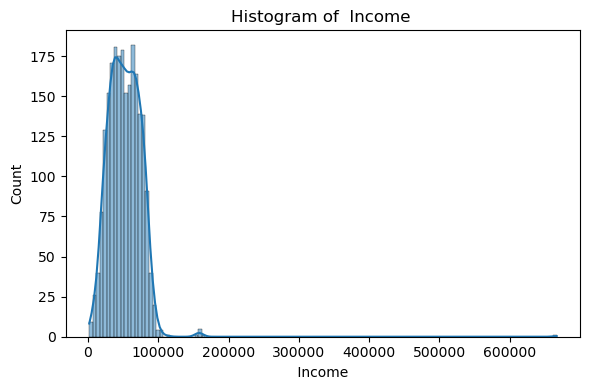

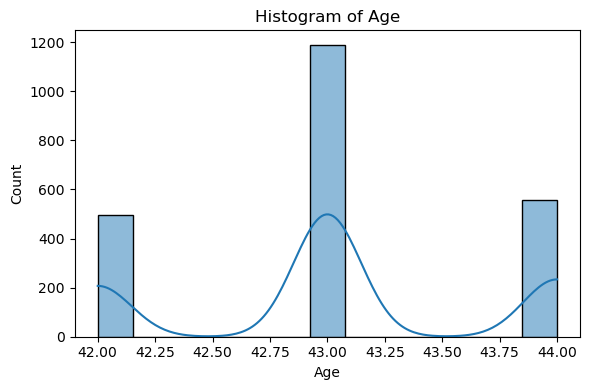

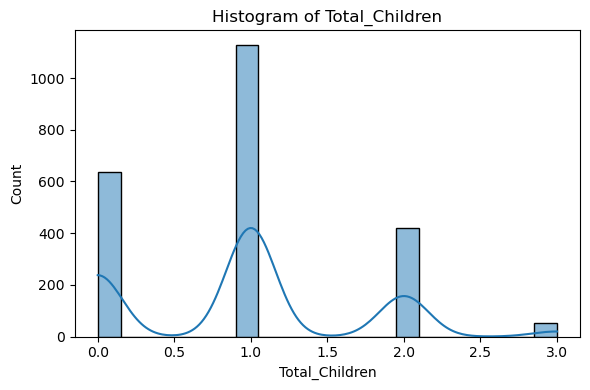

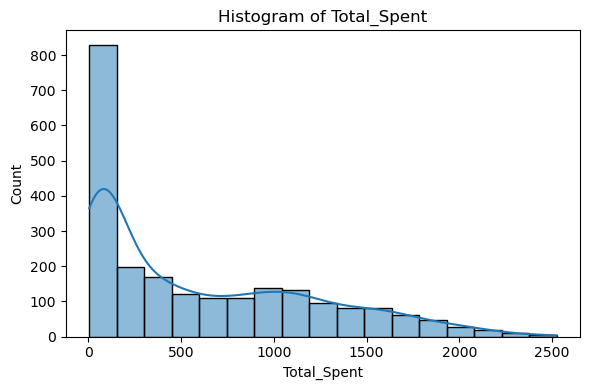

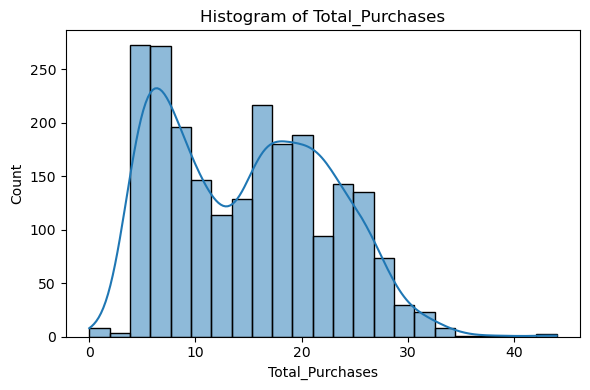

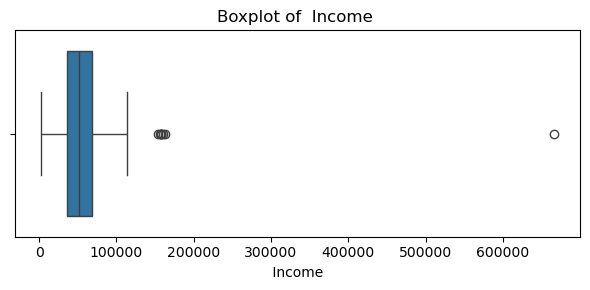

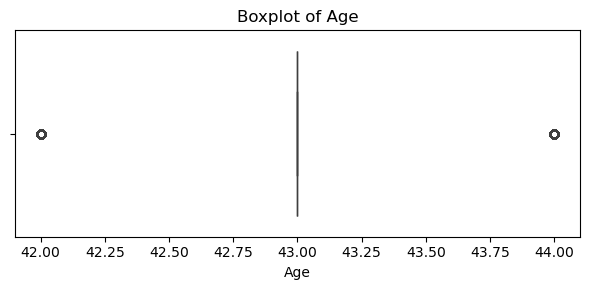

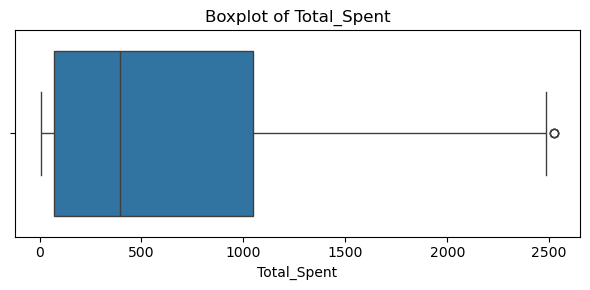

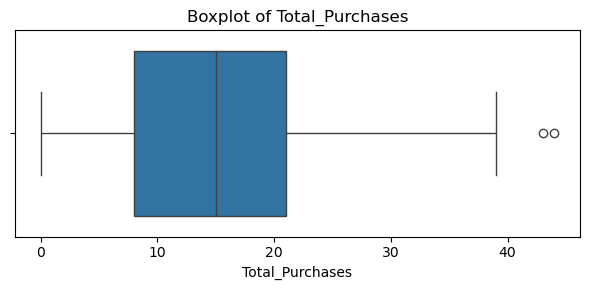

In [40]:
numeric_cols = marketing_campaign.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms for a selection
hist_cols = [' Income ','Age','Total_Children','Total_Spent','Total_Purchases']
for c in hist_cols:
    if c in marketing_campaign.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(marketing_campaign[c].dropna(), kde=True)
        plt.title(f'Histogram of {c}')
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f'hist_{c}.png'))
        plt.show()
        plt.close()


# Boxplots to inspect outliers
for c in [' Income ','Age','Total_Spent','Total_Purchases']:
    if c in marketing_campaign.columns:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=marketing_campaign[c].dropna())
        plt.title(f'Boxplot of {c}')
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f'box_{c}.png'))
        plt.show()
        plt.close()


# Simple outlier capping at 1st and 99th percentiles for numeric features
def cap_series(s, lower_q=0.01, upper_q=0.99):
    low = s.quantile(lower_q)
    high = s.quantile(upper_q)
    return s.clip(lower=low, upper=high)


for c in [' Income ','Total_Spent','Total_Purchases']:
    if c in marketing_campaign.columns:
        capped = cap_series(marketing_campaign[c])
        marketing_campaign[c+'_capped'] = capped

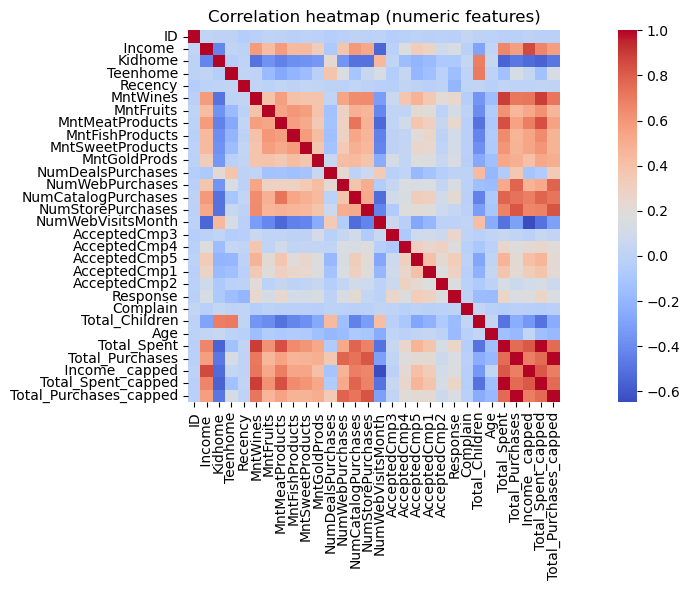

In [41]:
corr_cols = [c for c in marketing_campaign.select_dtypes(include=[np.number]).columns if marketing_campaign[c].nunique()>1]
plt.figure(figsize=(12,6))
cm = marketing_campaign[corr_cols].corr()
sns.heatmap(cm, annot=False, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation heatmap (numeric features)')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'correlation_heatmap.png'))
plt.show()
plt.close()

In [42]:
results = {}

# a) Older individuals -> prefer in-store shopping (NumStorePurchases)
if 'Age' in marketing_campaign.columns and 'NumStorePurchases' in marketing_campaign.columns:
    sp_corr, sp_p = stats.spearmanr(marketing_campaign['Age'].fillna(0), marketing_campaign['NumStorePurchases'].fillna(0))
    results['age_store_spearman'] = (sp_corr, sp_p)
    older = marketing_campaign[marketing_campaign['Age']>=60]['NumStorePurchases'].dropna()
    younger = marketing_campaign[marketing_campaign['Age']<60]['NumStorePurchases'].dropna()
    if len(older)>10 and len(younger)>10:
        tstat, pval = stats.mannwhitneyu(older, younger, alternative='two-sided')
        results['age_store_mannwhitney'] = (tstat, pval)


# b) Customers with children -> online shopping (NumWebPurchases)
if 'Total_Children' in marketing_campaign.columns and 'NumWebPurchases' in marketing_campaign.columns:
    with_children = marketing_campaign[marketing_campaign['Total_Children']>0]['NumWebPurchases'].dropna()
    without_children = marketing_campaign[marketing_campaign['Total_Children']==0]['NumWebPurchases'].dropna()
    if len(with_children)>10 and len(without_children)>10:
        t, p = stats.ttest_ind(with_children, without_children, equal_var=False)
        results['children_web_ttest'] = (t, p)


# c) Store sales cannibalization by other channels
if all(c in marketing_campaign.columns for c in ['NumStorePurchases','NumWebPurchases','NumCatalogPurchases']):
    marketing_campaign['Other_Channel_Purchases'] = marketing_campaign['NumWebPurchases'].fillna(0) + marketing_campaign['NumCatalogPurchases'].fillna(0)
    corr, p = stats.pearsonr(marketing_campaign['NumStorePurchases'].fillna(0), marketing_campaign['Other_Channel_Purchases'].fillna(0))
    results['store_vs_other_pearson'] = (corr, p)


# d) US vs rest: total purchase volumes
if 'Country' in marketing_campaign.columns and 'Total_Spent' in marketing_campaign.columns:
    us = marketing_campaign[marketing_campaign['Country']=='USA']['Total_Spent'].dropna()
    rest = marketing_campaign[marketing_campaign['Country']!='USA']['Total_Spent'].dropna()
    if len(us)>10 and len(rest)>10:
        t,u_p = stats.mannwhitneyu(us, rest, alternative='two-sided')
        results['usa_vs_rest_mannwhitney'] = (t, u_p)
    results['usa_sum'] = us.sum()
    results['rest_sum'] = rest.sum()


# Print results
print('\nHypothesis testing results:')
for k,v in results.items():
    print(k, v)


Hypothesis testing results:
age_store_spearman (-0.10391957717489862, 8.266141010548878e-07)
children_web_ttest (-3.541893836382714, 0.0004108102700005601)
store_vs_other_pearson (0.6153592978630218, 1.4705856043014408e-233)
usa_sum 0
rest_sum 1356988



Product revenues:
MntWines            680816
MntMeatProducts     373968
MntGoldProds         98609
MntFishProducts      84057
MntSweetProducts     60621
MntFruits            58917
dtype: int64


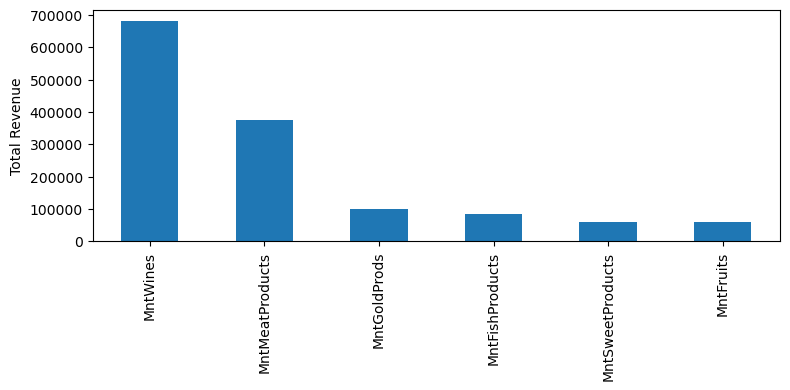

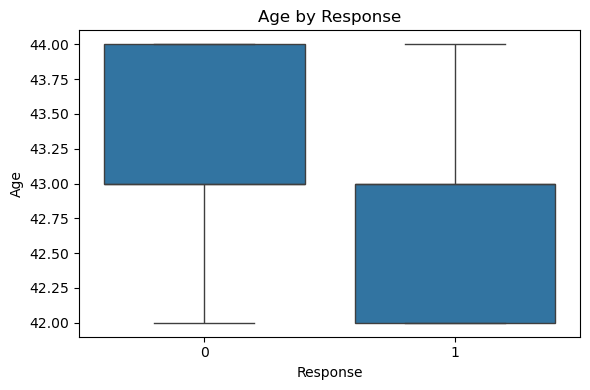

Age difference responders vs non-responders t=-8.053, p=0.0000

Top countries by accepted last campaign:
Country
SP     176
SA      52
CA      38
AUS     23
GER     17
IND     13
US      13
ME       2
Name: count, dtype: int64


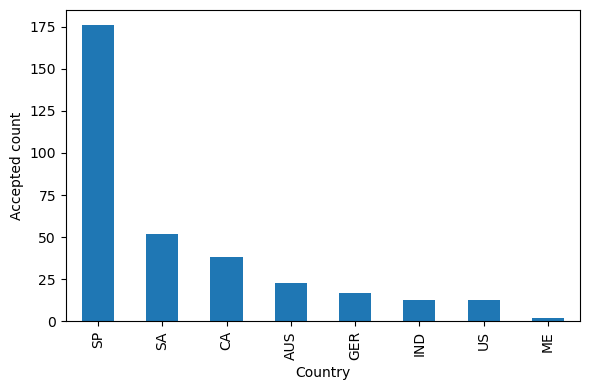

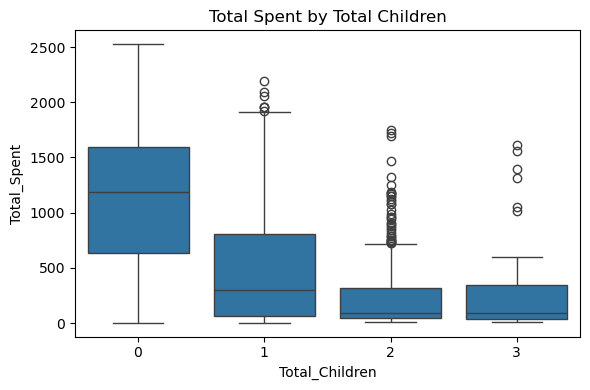

Correlation Total_Children vs Total_Spent: -0.484, p=0.0000

Education counts among complainants:
Education
Graduation    14
2N Cycle       4
Master         2
Phd            1
Name: count, dtype: int64


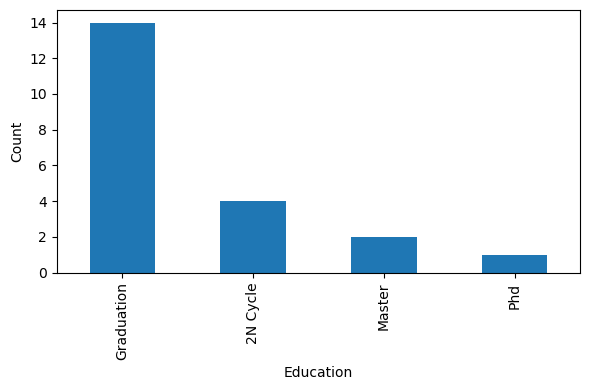

In [ ]:
# a) Top-performing products and lowest revenue (by monetary columns)
if money_cols:
    prod_revenue = marketing_campaign[money_cols].sum().sort_values(ascending=False)
    print('\nProduct revenues:')
    print(prod_revenue)
    plt.figure(figsize=(8,4))
    prod_revenue.plot(kind='bar')
    plt.ylabel('Total Revenue')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'product_revenues.png'))
    plt.show()
    plt.close()


# b) Age vs acceptance of last campaign
resp_col = None
for cand in ['Response','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2']:
    if cand in marketing_campaign.columns:
        resp_col = cand
        break
if resp_col and 'Age' in marketing_campaign.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=marketing_campaign[resp_col].fillna(0).astype(int), y=marketing_campaign['Age'])
    plt.title(f'Age by {resp_col}')
    plt.xlabel(resp_col)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'age_by_{resp_col}.png'))
    plt.show()
    plt.close()
    resp = marketing_campaign[marketing_campaign[resp_col]==1]['Age'].dropna()
    nonresp = marketing_campaign[marketing_campaign[resp_col]==0]['Age'].dropna()
    if len(resp)>10 and len(nonresp)>10:
        t,p = stats.ttest_ind(resp, nonresp, equal_var=False)
        print(f'Age difference responders vs non-responders t={t:.3f}, p={p:.4f}')


# c) Country with highest number of customers who accepted the last campaign
if resp_col and 'Country' in marketing_campaign.columns:
    accepted = marketing_campaign[marketing_campaign[resp_col]==1]
    top_country = accepted['Country'].value_counts().head(10)
    print('\nTop countries by accepted last campaign:')
    print(top_country)
    plt.figure(figsize=(6,4))
    top_country.plot(kind='bar')
    plt.ylabel('Accepted count')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'top_countries_accepted.png'))
    plt.show()
    plt.close()


# d) Pattern: number of children at home vs total expenditure
if 'Total_Children' in marketing_campaign.columns and 'Total_Spent' in marketing_campaign.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=marketing_campaign['Total_Children'].astype(int), y=marketing_campaign['Total_Spent'])
    plt.title('Total Spent by Total Children')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'children_vs_spent.png'))
    plt.show()
    plt.close()
    corr_children_spent, p_cs = stats.spearmanr(marketing_campaign['Total_Children'].fillna(0), marketing_campaign['Total_Spent'].fillna(0))
    print(f'Correlation Total_Children vs Total_Spent: {corr_children_spent:.3f}, p={p_cs:.4f}')

# e) Education levels among customers who complained
if 'Complain' in marketing_campaign.columns and 'Education' in marketing_campaign.columns:
    complainers = marketing_campaign[marketing_campaign['Complain']==1]
    edu_counts = complainers['Education'].value_counts()
    print('\nEducation counts among complainants:')
    print(edu_counts)
    plt.figure(figsize=(6,4))
    edu_counts.plot(kind='bar')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'complainers_education.png'))
    plt.show()
    plt.close()